In [1]:
from __future__ import division
import onmt
import torch
import numpy as np
from torch.autograd import Variable
from argparse import Namespace
import os
import math
import codecs
import torch
import torchtext.data
import torchtext.vocab
import onmt.IO
import opts
from itertools import takewhile, count
from sklearn.decomposition import PCA
import json
from matplotlib import pyplot as plt
from sklearn import preprocessing

### Functions copied from the word embedding bias implementation:

In [ ]:
def v(word, words, vecs,index):
	return vecs[index[word]]

def doPCA(pairs, words, vecs,index,num_components = 10):
	matrix = []
	filtered_pairs = []
	for a,b in pairs:
		if a in words and b in words:
			filtered_pairs.append([a,b])

	for a, b in filtered_pairs:
		center = (v(a, words, vecs,index) + v(b, words, vecs,index))/2
		matrix.append(v(a, words, vecs,index) - center)
		matrix.append(v(b, words, vecs,index) - center)
	matrix = np.array(matrix)
	pca = PCA(n_components = num_components)
	pca.fit(matrix)
	# bar(range(num_components), pca.explained_variance_ratio_)
	return pca
def drop(u, v):
    return u - v * u.dot(v) / v.dot(v)

### Functions for performing intervention

In [11]:
# def cast_to_numpy(score):
# 	return np.array([i.numpy() for i in score])

def cal_log(translator,batches,idx,data,alpha,gender_direction):
    """
    Calculate the probabilities of a pair of sentences(male and female) in a batch with index idx & idx +1
    """
	male_prob=translator._runTarget(batches[idx],data,alpha,gender_direction)
	female_prob=translator._runTarget(batches[idx+1],data,alpha,gender_direction)
	return [male_prob[0],female_prob[0]]
def do_intervention(translator,batch,data,alpha,gender_direction,fields,tgt_woi_list,tgt_woi_pos):
    """
    This function calculates probabilities of each word of 
    interest in the specified positions in a sentence during intervention.
    """
	_, src_lengths = batch.src
	src = onmt.IO.make_features(batch, 'src')
	_,_,_,_,allallScore,all_out_list = translator.translateBatch(batch,data,alpha,gender_direction)
	cond_p = []
	top_p = []
	for pos,woi in zip(tgt_woi_pos,tgt_woi_list):
		cond_p.append(np.around(all_out_list[0][0][pos][fields['tgt'].vocab.stoi[woi]],decimals = 2))
	for pos in range(len(tgt_woi_pos)):	
		top_result = all_out_list[0][0][pos].topk(5, 0, True, True)
		top_p.append((np.around(list(top_result[0]),decimals = 2),[fields['tgt'].vocab.itos[i] for i in list(top_result[1])]))
	translation_result = translator.translate(batch,data,alpha,gender_direction)
	return (translation_result[0],np.around(translation_result[2],decimals = 2),cond_p,top_p)
def read_sentences(src,tgt):
    sentences = []
    with codecs.open(tgt, "r", "utf-8") as corpus_file:
            for i, line in enumerate(corpus_file):
                sentences.append(line)
    with codecs.open(src, "r", "utf-8") as corpus_file:
        for i, line in enumerate(corpus_file):
            sentences.append(line)
    return [line[:-(line[-1] == '\n') or len(line)+1] for line in sentences[:3]]

## Initializing the parameters

In [7]:
model_path = '../models/ccep_model_acc_59.39_ppl_7.57_e10.pt'
src_path = 'data/bias_src.txt'
tgt_path = 'data/bias_tgt.txt'
checkpoint = torch.load(model_path,map_location=lambda storage, loc: storage)
fields = onmt.IO.load_fields(checkpoint['vocab'])
model_opt = checkpoint['opt']
model = onmt.ModelConstructor.make_base_model(
							model_opt, fields, False,checkpoint)

Loading model parameters.


In [ ]:
opt = Namespace(attn_debug=False, batch_size=30, beam_size=5, dump_beam='', dynamic_dict=True, gpu=-1, max_sent_length=100, model=model_path, n_best=10, output='pred.txt', replace_unk=False, share_vocab=False, 
				src=src_path, src_img_dir='', verbose=True,tgt =tgt_path)

dummy_parser = argparse.ArgumentParser(description='train.py')
opts.model_opts(dummy_parser)
dummy_opt = dummy_parser.parse_known_args([])[0]
opt.cuda = opt.gpu > -1
if opt.cuda:
	torch.cuda.set_device(opt.gpu)
translator = onmt.Translator(opt, dummy_opt.__dict__)

This section deals with initializing opts and calculates the gender direction based on the NIPS paper. It only needs to be ran once. 

In [12]:
words = fields["src"].vocab.itos
vecs = model.encoder.embeddings.word_lut.weight.data.numpy()
vecs_normalized= preprocessing.normalize(vecs, norm='l2')# After normalization.
index = {w: i for i, w in enumerate(words)}
with open('onmt/debiaswe/data/definitional_pairs.json', "r") as f:
	defs = json.load(f)
print("definitional", defs)
gender_direction_nmt_np = doPCA(defs,words, vecs_normalized,index).components_[0]
gender_direction_nmt = Variable(torch.from_numpy(gender_direction_nmt_np))

Loading model parameters.
definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]


## Constructing Example Batches for Translation

In [47]:
def construct_data(adjs = ['great','grande','grand'],occup_path = 'data/occupations.txt',occup_path_fr = 'data/occupation_french.txt'):
    
    occupations = []
    with codecs.open(occup_path, "r", "utf-8") as corpus_file:
            for i, line in enumerate(corpus_file):
                occupations.append(line)
    occupations = [occup[:-1] if occup[-1]=='\n' else occup for occup in occupations]
    occupations = [occup[:-1] if occup[-1]==' ' else occup for occup in occupations]
    print(occupations)
    occup_sentence = ['This '+occup + ' is '+adjs[0]+ '.' for occup in occupations]
    occup_sentence = [val for val in occup_sentence for _ in (0, 1)]

    
    occupations_fr = []
    with codecs.open(occup_path_fr, "r", "utf-8") as corpus_file:
            for i, line in enumerate(corpus_file):
                occupations_fr.extend(line.split(','))
    print(occupations_fr)

    # occupations_fr = [line[:-(line[-1] == '\n') or len(line)+1] for line in occupations_fr] 
    occupations_fr = [occup[:-1] if occup[-1]=='\n' else occup for occup in occupations_fr]
    occupations_fr = [occup[:-1] if occup[-1]==' ' else occup for occup in occupations_fr]

    print(occupations_fr)

    occup_sentence_fr = [occupations_fr[i] + ' est ' + adjs[1]+ '.' if i%2==0 else occupations_fr[i] + ' est '+adjs[2]+ '.' for i in range(len(occupations_fr))]
    print(occup_sentence_fr)

    with open(opt.src, "w",encoding='utf-8') as file:
        file.writelines( "%s\n" % item for item in occup_sentence )
    with open(opt.tgt, "w",encoding='utf-8') as file:
        file.writelines( "%s\n" % item for item in occup_sentence_fr )
    data = onmt.IO.ONMTDataset(
        opt.src, opt.tgt, fields,
        use_filter_pred=False)
    test_data = onmt.IO.OrderedIterator(
        dataset=data, device=opt.gpu,
        batch_size=opt.batch_size, train=False, sort=False,
        shuffle=False)
    batches = []
    for b in torchtext.data.batch(test_data.data(), 1,test_data.batch_size_fn):
        batches.append(sorted(b, key=test_data.sort_key))
    example_batches = []
    for idx, minibatch in enumerate(batches):
        # fast-forward if loaded from state
        print(minibatch[0].src)
        example_batches.append(torchtext.data.Batch(minibatch, test_data.dataset, test_data.device, test_data.train))
    return example_batches

### Experiments

In [44]:
# tgt_woi_list = ['Cette','Cet','infirmière','infirmier','grande','grand']
# tgt_woi_pos=[0,0,1,1,4,4]
# # tgt_woi_list = ['Cette','Cet','infirmière','infirmier','jolie','joli']
# # tgt_woi_pos=[0,0,1,1,4,4]
# # tgt_woi_list = ['Cette','Cet','infirmière','infirmier','forte','fort']
# # tgt_woi_pos=[0,0,1,1,4,4]
# intervene_pos = np.ones(len(occupations),dtype = 'int')
# whole_sentences = read_sentences(opt.src,opt.tgt)
# print(whole_sentences)

#### Experiment 1

 In this experiment, I perturbed on the occupation and see when the translation flipped. In the plot section you can see the coordinates where the the female and male curves intersect. 

In [54]:
def experiment1(alphas,example_batches):
    
    p_list = []
    cond_p_list = []
    top_p_list = []
    for idx in range(len(occupations)):
        print(idx)
        tmp_p_list = []
        for i in alphas: 
            length = example_batches[2*idx].src[1][0]
            tmp_array = np.zeros(length)
            tmp_array[intervene_pos[idx]] = i
            alpha = Variable(torch.FloatTensor(list(tmp_array)),requires_grad = True)
            # 	translation_text,translation_p,cond_p,top_p= do_intervention(translator,example_batches[0],data,alpha,gender_direction_nmt,fields,tgt_woi_list,tgt_woi_pos)
            # 	cond_p_list.append(cond_p)
            # 	top_p_list.append(top_p)
            # 	print(translation_text,translation_p,cond_p,top_p)
            tmp_p_list.append(cal_log(translator,example_batches,2*idx,data,alpha,gender_direction_nmt))
        p_list.append(tmp_p_list)
    p_array = np.array(p_list)
    return p_array

In [56]:
alphas = np.arange(-1, 1, 0.01)
example_batches = construct_data()
p_array = experiment1(alphas,example_batches)

['nurse', 'dancer', 'lawyer', 'singer', 'professor']
['Cette infirmière', 'Cet infirmier \n', 'Cette danseuse', 'Ce danseur \n', 'Cette avocate', 'Cet avocat\n', 'Cette chanteuse', 'Ce chanteur\n', 'Cette professeure', 'Ce professeur']
['Cette infirmière', 'Cet infirmier', 'Cette danseuse', 'Ce danseur', 'Cette avocate', 'Cet avocat', 'Cette chanteuse', 'Ce chanteur', 'Cette professeure', 'Ce professeur']
['Cette infirmière est grande.', 'Cet infirmier est grand.', 'Cette danseuse est grande.', 'Ce danseur est grand.', 'Cette avocate est grande.', 'Cet avocat est grand.', 'Cette chanteuse est grande.', 'Ce chanteur est grand.', 'Cette professeure est grande.', 'Ce professeur est grand.']
('This', 'nurse', 'is', 'great.')
('This', 'nurse', 'is', 'great.')
('This', 'dancer', 'is', 'great.')
('This', 'dancer', 'is', 'great.')
('This', 'lawyer', 'is', 'great.')
('This', 'lawyer', 'is', 'great.')
('This', 'singer', 'is', 'great.')
('This', 'singer', 'is', 'great.')
('This', 'professor', 'is

//anaconda/envs/py36/lib/python3.6/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)


1
2
3
4


(5, 200, 2)
intersection point -0.62 -4.09210681915 nurse
intersection point -0.03 -2.55147886276 dancer
intersection point 0.42 -2.85262608528 lawyer
intersection point 0.29 -3.40982198715 singer
intersection point 0.69 -5.21886396408 professor


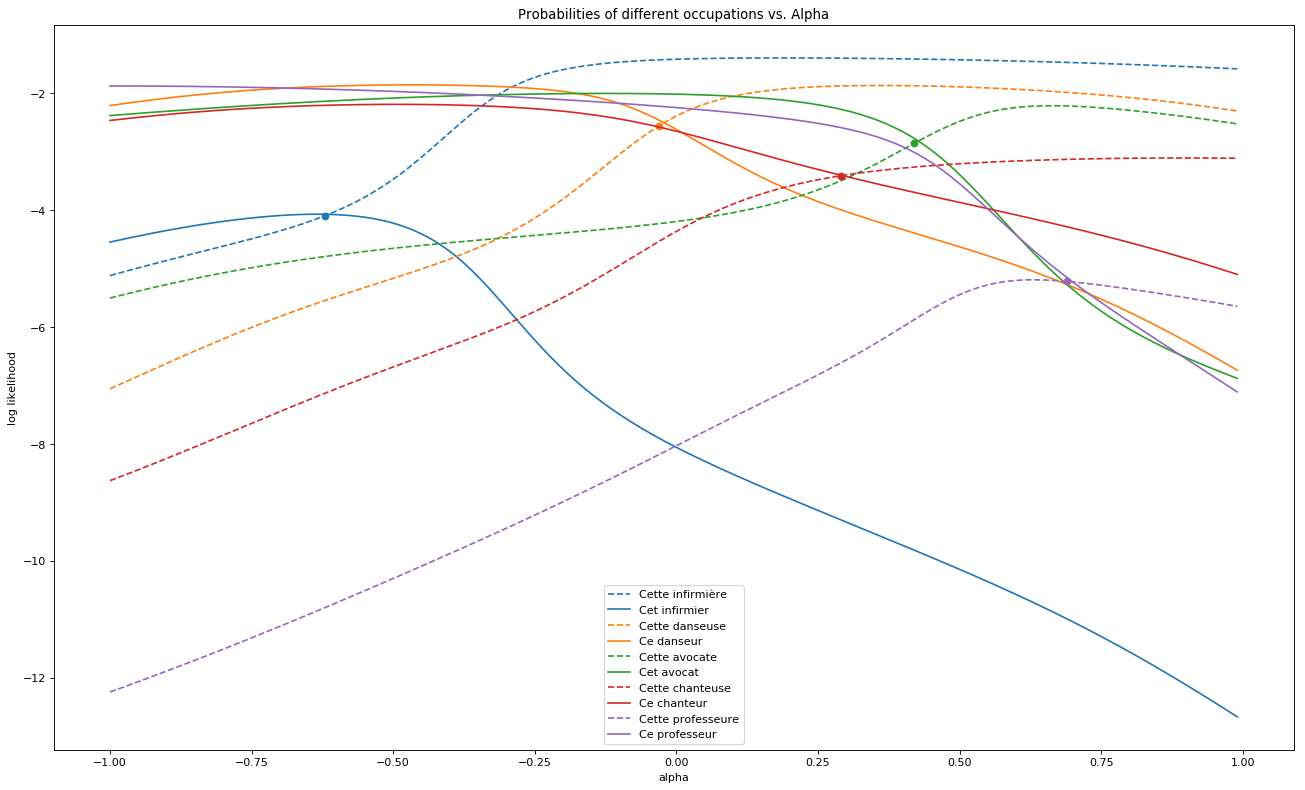

In [30]:
fig=plt.figure(figsize=(20, 12), dpi= 80, facecolor='w', edgecolor='k')

# pos_array = np.array(cond_p_list).T
print(p_array.shape)
# p_array = np.reshape(p_array,(p_array.shape[0],2,int(p_array.shape[1]/2)))
# for i in range(6):
# 	plt.plot(alpha_range,pos_array[i,:],label = tgt_woi_list[i])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# print(p_array.shape)
alpha_balance = []
for i in range(p_array.shape[0]):
        plt.plot(alpha_range,p_array[i,:,0],'--',label = occupations_fr[2*i],color=colors[i])
        plt.plot(alpha_range,p_array[i,:,1],'-',label = occupations_fr[2*i+1],color=colors[i])
        idx = np.argwhere(np.diff(np.sign(p_array[i,:,0]- p_array[i,:,1])) != 0).reshape(-1) + 0
        alpha_balance.append(alpha_range[idx][0])
        print("intersection point",alpha_range[idx][0], p_array[i,:,0][idx][0],occupations[i])
        plt.plot(alpha_range[idx], p_array[i,:,0][idx], 'o',color = colors[i])


plt.xlabel('alpha')
plt.ylabel('log likelihood')
plt.legend()
plt.title('Probabilities of different occupations vs. Alpha')
plt.show()

#### Experiment 2
In this section, I compared the value alpha' needed debias the word embedding with the alpha needed to reach the balance(from experiment 1) to prove that debiasing the word embedding won't debias the translation. 

In [22]:
debiasp_list = []
originalp_list = []
debias_factor_lst = []
for idx in range(len(occupations)):
    print(idx)
    length = example_batches[2*idx].src[1][0]
    tmp_array = np.zeros(length)
    alpha0 = Variable(torch.FloatTensor(list(tmp_array)),requires_grad = True)
    embedding = vecs[fields['src'].vocab.stoi[occupations[idx]],:]
    debias_factor = -embedding.dot(gender_direction_nmt_np)/gender_direction_nmt_np.dot(gender_direction_nmt_np) 
    tmp_array[intervene_pos[idx]] = debias_factor
    debias_factor_lst.append(debias_factor)
    alpha = Variable(torch.FloatTensor(list(tmp_array)),requires_grad = True)   
    # 	translation_text,translation_p,cond_p,top_p= do_intervention(translator,example_batches[0],data,alpha,gender_direction_nmt,fields,tgt_woi_list,tgt_woi_pos)
    # 	cond_p_list.append(cond_p)
    # 	top_p_list.append(top_p)
    # 	print(translation_text,translation_p,cond_p,top_p)
    debiasp_list.append(cal_log(translator,example_batches,2*idx,data,alpha,gender_direction_nmt))
    originalp_list.append(cal_log(translator,example_batches,2*idx,data,alpha0,gender_direction_nmt))
# for idx in range(len(occupations)):
#     print(occupations[idx])
#     print(fields['src'].vocab.stoi[occupations[idx]])

0


//anaconda/envs/py36/lib/python3.6/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)


1
2
3
4


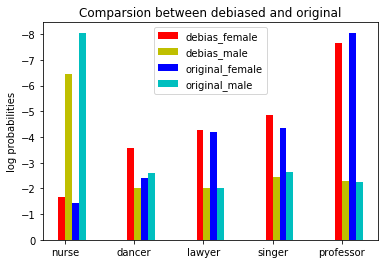

In [29]:
N = len(occupations)
debiasp_array = np.array(debiasp_list)
originalp_array = np.array(originalp_list)

ind = np.arange(N)  # the x locations for the groups
width = 0.1       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind,debiasp_array[:,0], width, color='r')
rects2 = ax.bar(ind + width, debiasp_array[:,1], width, color='y')
rects3 = ax.bar(ind + 2*width, originalp_array[:,0], width, color='b')
rects4 = ax.bar(ind + 3*width, originalp_array[:,1], width, color='c')

# add some text for labels, title and axes ticks
ax.set_ylabel('log probabilities')
ax.set_title('Comparsion between debiased and original')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(occupations)
plt.gca().invert_yaxis()

ax.legend((rects1[0], rects2[0],rects3[0],rects4[0]), ('debias_female','debias_male','original_female','original_male'))


NameError: name 'values' is not defined

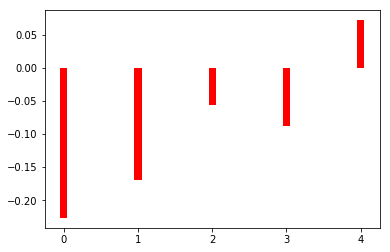

In [28]:
N = len(occupations)
debiasf_array = np.array(debias_factor_lst)
ind = np.arange(N)  # the x locations for the groups
width = 0.1       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind,debiasf_array, width, color='r')
rects2 = ax.bar(ind + width, values[0,:], width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('factors')
ax.set_title('comparsion between balanced alpha and debias factor')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(occupations)

ax.legend((rects1[0], rects2[0],rects3[0],rects4[0]), ('debias_factor','balanced_alpha'))

The following plot are the alpha values need to reach balance for different adjectives. The results is not as expected as you can see. 

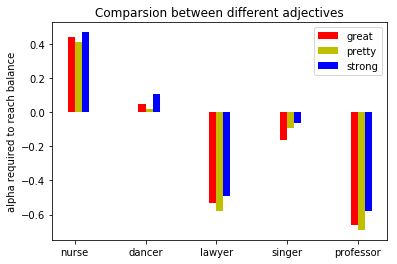

In [69]:
N = len(occupations)
debiasp_array = np.array(debiasp_list)
originalp_array = np.array(originalp_list)
adjectives = ['great','pretty','strong']
values = np.array([[.44,.05,-.53,-.16,-.66],[.41,.02,-.58,-.09,-.69],[.47,.11,-.49,-.06,-.58]])
ind = np.arange(N)  # the x locations for the groups
width = 0.1       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind,values[0,:], width, color='r')
rects2 = ax.bar(ind + width, values[1,:], width, color='y')
rects3 = ax.bar(ind + 2*width, values[2,:], width, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('alpha required to reach balance')
ax.set_title('Comparsion between different adjectives')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(occupations)

ax.legend((rects1[0], rects2[0],rects3[0],rects4[0]), adjectives)

# Random Testing Code 

In [53]:
import torch.nn.functional as F
from numpy import linalg as LA
print(LA.norm(doPCA(defs,words, vecs_normalized,index).components_[0]))
F.normalize(torch.mm(alpha.unsqueeze(1),gender_direction_nmt.unsqueeze(0)), p=2, dim=1).unsqueeze(1).squeeze(1)

1.0


Variable containing:
-0.0000  0.0000  0.0000  ...  -0.0000  0.0000  0.0000
-0.0381  0.0160  0.0378  ...  -0.0354  0.0158  0.1086
-0.0000  0.0000  0.0000  ...  -0.0000  0.0000  0.0000
-0.0000  0.0000  0.0000  ...  -0.0000  0.0000  0.0000
-0.0000  0.0000  0.0000  ...  -0.0000  0.0000  0.0000
[torch.FloatTensor of size 5x500]

In [15]:
alpha_range = np.arange(-2, 3, .5)
intervene_pos = np.ones(len(occupations),dtype = 'int')
# alpha = Variable(torch.FloatTensor([0,0,0,0,0]))
for idx in range(len(occupations)):
    print(occupations[idx])
    for i in alpha_range:
        print(i)
        length = example_batches[2*idx].src[1][0]
        tmp_array = np.zeros(length)
        tmp_array[intervene_pos[idx]] = i
        alpha = Variable(torch.FloatTensor(list(tmp_array)),requires_grad = True)
        print(translator.translate(example_batches[2*idx],data,alpha,gender_direction_nmt)[0])

nurse
-2.0
[[['Ce', '<unk>', 'est', 'grand', '.'], ['Ce', 'troupeau', 'est', 'grand', '.'], ['Ce', '<unk>', 'est', 'génial', '.'], ['Ce', '<unk>', 'est', 'très', 'important', '.'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', '.'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', '!'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', 'de', 'le', 'faire', '.'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', 'de', 'faire', '.'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', 'de', 'le', 'voir', '.'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', 'de', 'la', '<unk>', '.']]]
-1.5
[[['Ce', '<unk>', 'est', 'grand', '.'], ['Ce', '<unk>', 'est', 'formidable', '.'], ['Ce', '<unk>', 'est', 'génial', '.'], ['Ce', '<unk>', 'est', 'très', 'important', '.'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', '.'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', '!'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir', 'de', 'le', 'faire', '.'], ['Ce', '<unk>', 'est', 'un', 'grand', 'plaisir',

[[['Ce', 'danseur', 'est', 'grand', '.'], ['Ce', '<unk>', 'est', 'grand', '.'], ['Ce', 'dernier', 'est', 'grand', '.'], ['Ce', 'danseur', 'est', 'très', 'grand', '.'], ['Ce', 'danseur', 'est', 'très', 'important', '.'], ['Ce', 'danseur', 'est', 'très', 'grand', '.', '.'], ['Ce', 'danseur', 'est', 'très', 'grand', '.', 'Il', 'y', 'a', 'un', 'grand', 'nombre', 'd', '’', '<unk>', '.'], ['Ce', 'danseur', 'est', 'très', 'grand', '.', 'Il', 'y', 'a', 'un', 'grand', 'nombre', 'd', '’', '<unk>', 'qui', 'sont', '<unk>', '.'], ['Ce', 'danseur', 'est', 'très', 'grand', '.', 'Il', 'y', 'a', 'un', 'grand', 'nombre', 'd', '’', '<unk>', ',', 'de', '<unk>', 'et', 'de', '<unk>', '.'], ['Ce', 'danseur', 'est', 'très', 'grand', '.', 'Il', 'y', 'a', 'un', 'grand', 'nombre', 'd', '’', '<unk>', ',', 'de', '<unk>', 'et', 'd', '’', '<unk>', '.']]]
-1.0
[[['Ce', 'danseur', 'est', 'grand', '.'], ['Ce', 'danseur', 'est', 'génial', '.'], ['Ce', 'danseur', 'est', 'très', 'grand', '.'], ['Ce', 'danseur', 'est', 'fo

[[['Ce', 'juriste', 'est', 'grand', '.'], ['Cet', 'avocat', 'est', 'grand', '.'], ['Ce', 'juriste', 'est', 'très', 'important', '.'], ['Ce', 'juriste', 'est', 'important', '.'], ['Cet', 'avocat', 'est', 'très', 'important', '.'], ['Ce', 'juriste', 'est', 'très', 'important', '.', 'Il', 'ne', "s'", 'agit', 'pas', "d'", 'un', 'avocat', '.'], ['Ce', 'juriste', 'est', 'très', 'important', '.', 'Il', 'ne', "s'", 'agit', 'pas', "d'", 'un', 'tel', 'avocat', '.'], ['Ce', 'juriste', 'est', 'très', 'important', '.', 'Il', 'ne', "s'", 'agit', 'pas', "d'", 'un', 'tel', 'avocat', ',', 'mais', "d'", 'un', 'tel', 'avocat', '.'], ['Ce', 'juriste', 'est', 'très', 'important', '.', 'Il', 'ne', "s'", 'agit', 'pas', "d'", 'un', 'tel', 'avocat', ',', "c'", 'est', 'un', 'avocat', '.'], ['Ce', 'juriste', 'est', 'très', 'important', '.', 'Il', 'ne', "s'", 'agit', 'pas', "d'", 'un', 'tel', 'avocat', ',', 'mais', "d'", 'un', 'tel', 'juriste', '.']]]
-1.0
[[['Ce', 'juriste', 'est', 'grand', '.'], ['Cet', 'avocat

[[['Ce', '<unk>', 'est', 'grand', '.'], ['Ce', '<unk>', 'est', 'génial', '.'], ['Ce', 'chanteur', 'est', 'grand', '.'], ['Ce', 'son', 'est', 'grand', '.'], ['Ce', '<unk>', 'est', 'très', 'beau', '.'], ['Ce', '<unk>', 'est', 'très', 'beau', '.', '!'], ['Ce', '<unk>', 'est', 'très', 'beau', '.', 'Il', 'y', 'a', 'beaucoup', 'de', 'choses', 'à', 'faire', '.'], ['Ce', '<unk>', 'est', 'très', 'beau', '.', 'Il', 'y', 'a', 'beaucoup', 'de', 'choses', 'à', 'voir', '.'], ['Ce', '<unk>', 'est', 'très', 'beau', '.', 'Il', 'y', 'a', 'un', 'peu', 'plus', 'de', 'temps', 'que', 'le', '<unk>', '.'], ['Ce', '<unk>', 'est', 'très', 'beau', '.', 'Il', 'y', 'a', 'un', 'peu', 'plus', 'de', 'temps', 'que', 'de', '<unk>', '.']]]
-1.5
[[['Ce', 'chanteur', 'est', 'grand', '.'], ['Ce', '<unk>', 'est', 'grand', '.'], ['Ce', '<unk>', 'est', 'génial', '.'], ['Ce', 'chanteur', 'est', 'génial', '.'], ['Ce', 'chanteur', 'est', 'très', 'grand', '.'], ['Ce', 'chanteur', 'est', 'très', 'grand', '.', '!'], ['Ce', 'chanteu

[[['Ce', 'professeur', 'est', 'grand', '.'], ['Ce', '<unk>', 'est', 'grand', '.'], ['Ce', 'père', 'est', 'grand', '.'], ['Ce', 'professeur', 'est', 'très', 'grand', '.'], ['Ce', 'Professeur', 'est', 'grand', '.'], ['Ce', 'professeur', 'est', 'très', 'grand', '.', '.'], ['Ce', 'professeur', 'est', 'très', 'grand', '.', 'Il', 'y', 'a', 'un', 'grand', 'nombre', 'd', '’', 'entre', 'eux', '.'], ['Ce', 'professeur', 'est', 'très', 'grand', '.', 'Il', 'y', 'a', 'un', 'grand', 'nombre', 'd', '’', 'entre', 'eux', 'qui', 'ont', 'été', '<unk>', '.'], ['Ce', 'professeur', 'est', 'très', 'grand', '.', 'Il', 'y', 'a', 'un', 'grand', 'nombre', 'd', '’', 'entre', 'eux', 'qui', 'ont', 'fait', 'l', '’', 'objet', 'd', '’', 'une', 'action', '.'], ['Ce', 'professeur', 'est', 'très', 'grand', '.', 'Il', 'y', 'a', 'un', 'grand', 'nombre', 'd', '’', 'entre', 'eux', 'qui', 'ont', 'fait', 'l', '’', 'objet', 'd', '’', 'une', 'formation', '.']]]
-1.5
[[['Ce', 'professeur', 'est', 'grand', '.'], ['Ce', 'professeur

[[['Cette', 'femme', 'est', 'excellente', '.'], ['Cette', 'femme', 'est', 'grande', '.'], ['Cette', '<unk>', 'est', 'excellente', '.'], ['Cette', 'jeune', 'femme', 'est', 'grande', '.'], ['Cette', 'jeune', 'femme', 'est', 'très', 'grande', '.'], ['Cette', 'jeune', 'femme', 'est', 'très', 'grande', '!'], ['Cette', 'jeune', 'femme', 'est', 'très', 'grande', ',', 'elle', 'est', 'très', 'belle', '.'], ['Cette', 'jeune', 'femme', 'est', 'très', 'grande', 'et', 'elle', 'est', 'très', 'belle', '.'], ['Cette', 'jeune', 'femme', 'est', 'très', 'grande', ',', 'elle', 'est', 'très', 'bonne', '.'], ['Cette', 'jeune', 'femme', 'est', 'très', 'grande', 'et', 'elle', 'est', 'très', 'heureuse', '.']]]
